<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем необходимые библиотеки

In [1]:
!pip install fast_ml


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from fast_ml.model_development import train_valid_test_split

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV

In [5]:
SEED = 7 # константа для random_state

Считываем данные и выводим общую информацию по таблице

In [6]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('C:/Users/alber/Python/data/Churn.csv')
df = data.copy()
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Столбцы `RowNumber, CustomerId, Surname` не нужны нам для обучения моделей, поэтому удалим их.

In [9]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

В нашем распоряжении 10000 объектов и 13 признаков, из которых один целевой(**Exited**). Пропуски есть только в столбце `Tenure`(около 10% от исходных), исследуем его. Сгруппируем данные относительно пропусков в `Tenure`.

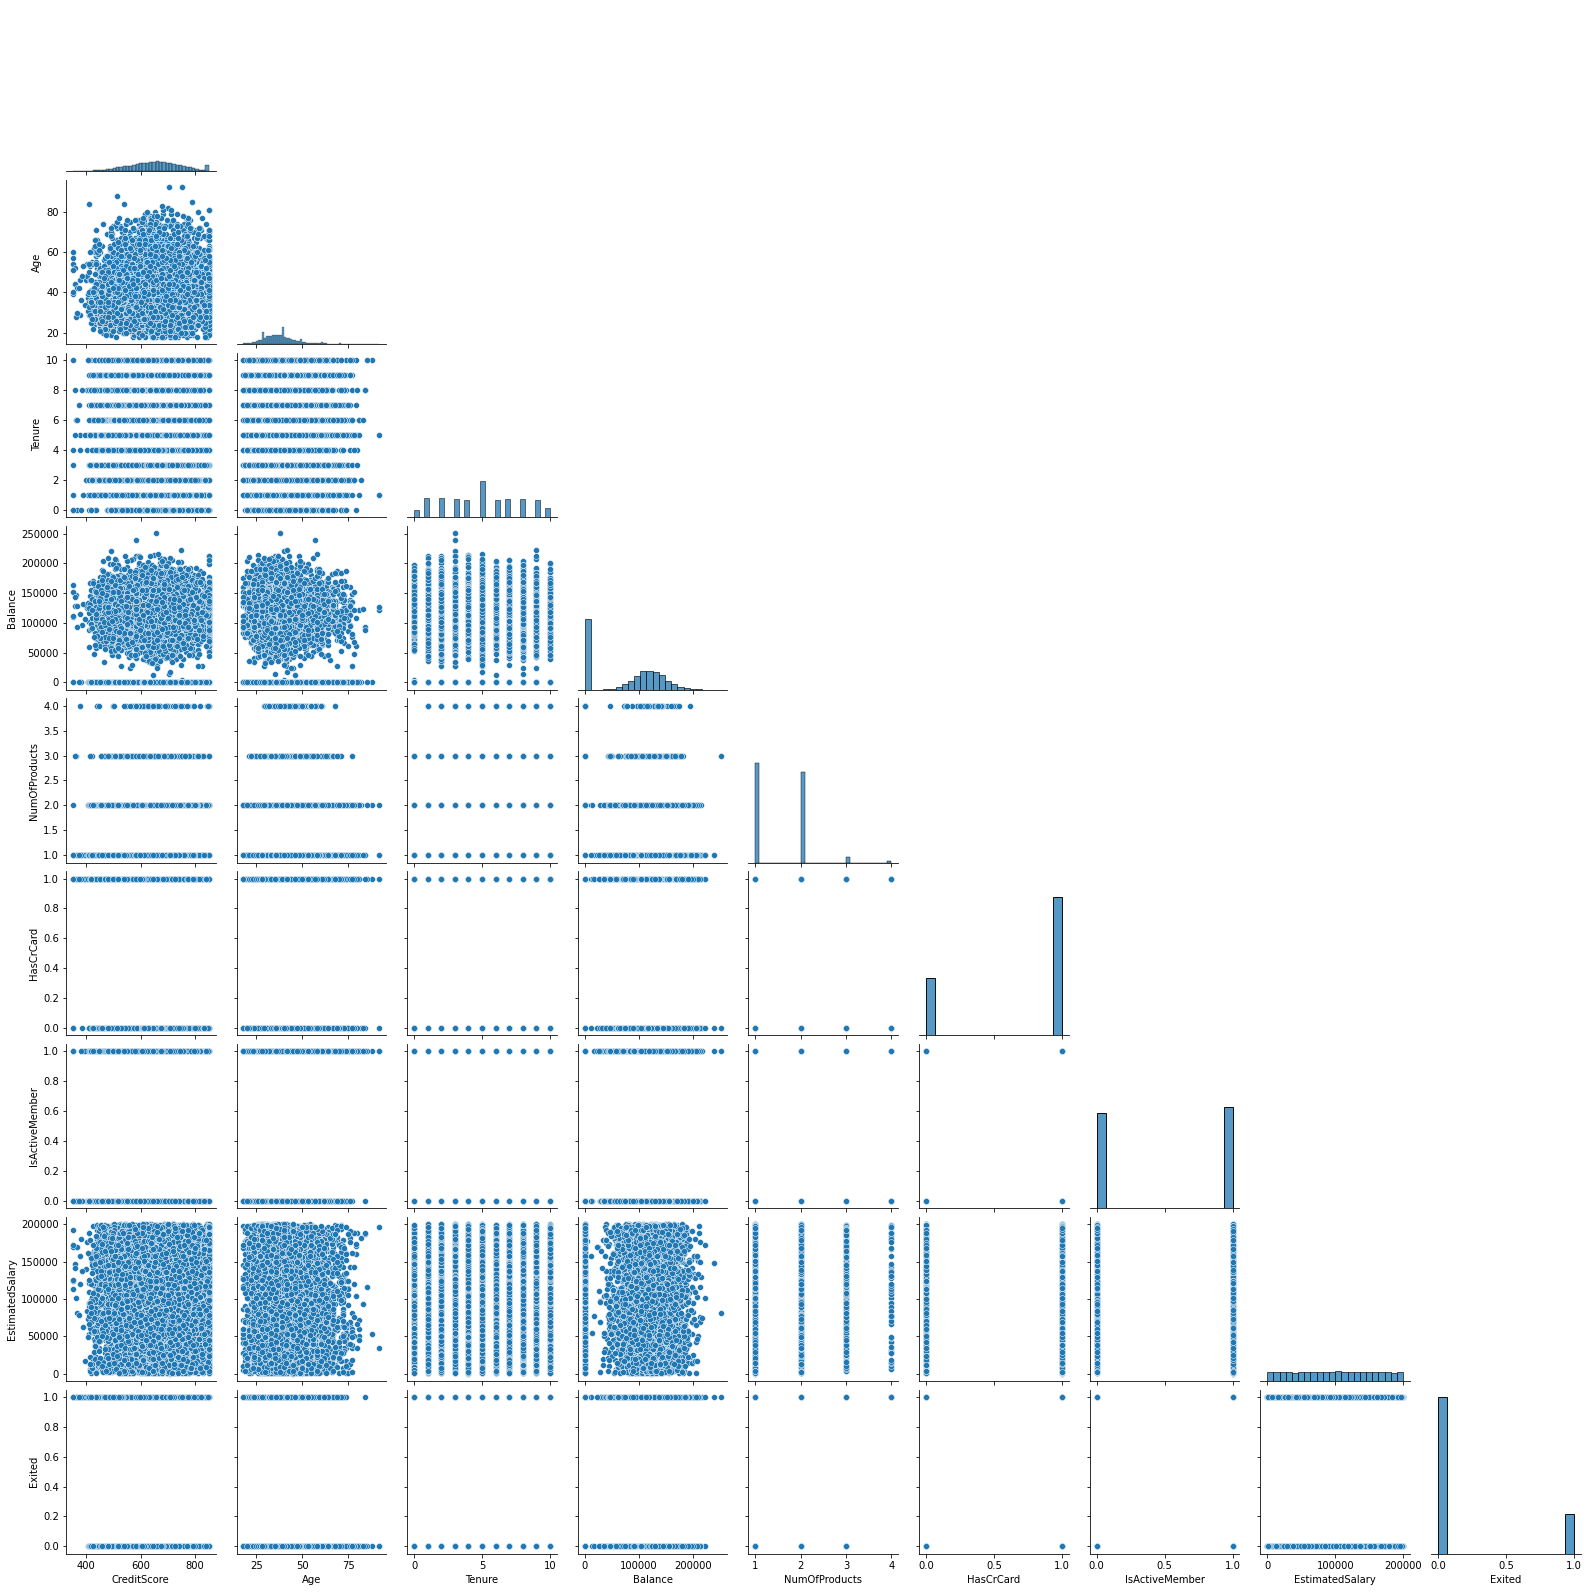

In [24]:
sns.pairplot(df, corner=True);

In [10]:
df.groupby(df['Tenure'].isna()).agg('mean')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Tenure,,,,,,,,,
False,650.736553,38.949181,4.99769,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
True,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320


Каких-то явных закономерностей нет, попробуем рассмотреть датафрейм только с пропусками в `Tenure`.

In [11]:
df_to_ex_na = df.loc[df['Tenure'].isna()]

In [12]:
df_to_ex_na.groupby(df_to_ex_na['Geography']).agg('mean')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,
France,640.950431,38.125000,NaN,61454.754720,1.549569,0.689655,0.519397,97440.155366,0.165948
Germany,658.310185,39.041667,NaN,120781.559444,1.509259,0.731481,0.458333,98843.680463,0.291667
Spain,654.349345,39.336245,NaN,63697.992882,1.510917,0.733624,0.541485,103024.047467,0.187773


In [13]:
df_to_ex_na.groupby(df_to_ex_na['IsActiveMember']).agg('mean')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Exited
IsActiveMember,,,,,,,,
0,651.089888,37.449438,NaN,81097.295034,1.521348,0.730337,94771.931034,0.269663
1,645.920259,39.797414,NaN,71341.308427,1.538793,0.691810,103408.328944,0.135776


In [14]:
df_to_ex_na.groupby(df_to_ex_na['Exited']).agg('mean')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.334711,37.121212,NaN,71951.095413,1.537190,0.716253,0.552342,99984.366446
1,637.010929,44.704918,NaN,92645.727486,1.502732,0.688525,0.344262,95990.840984


In [15]:
df_to_ex_na.groupby(df_to_ex_na['HasCrCard']).agg('mean')

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
HasCrCard,,,,,,,,
0,651.570342,38.422053,NaN,73456.211787,1.551331,0.543726,103489.070190,0.216730
1,647.181115,38.739938,NaN,77200.742570,1.521672,0.496904,97426.236037,0.195046


Каких-то правил для заполнения пропусков я не нашёл

Посмотрим распределение и уникальные значения`Tenure`.

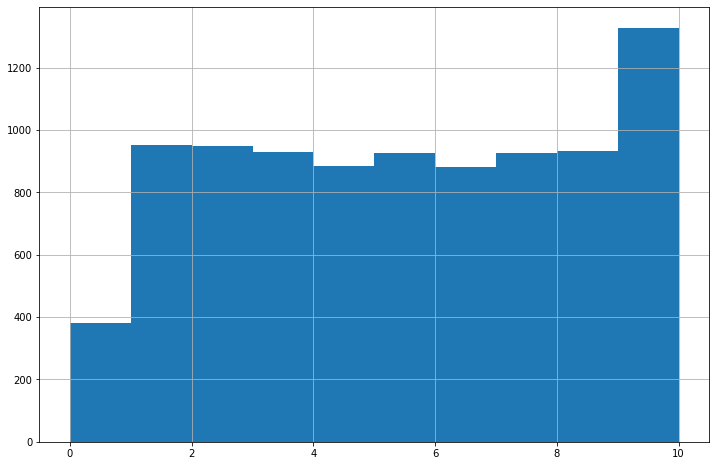

In [16]:
df['Tenure'].hist(figsize=(12, 8));

распределение похоже на равномерное

In [17]:
sorted(df['Tenure'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

В уникальных значених присутствуют только целые числа

посмотрим зависит ли медиана столбца от географического положения, наличия кредитной карты или активности

In [18]:
print('Germany:', df.loc[df['Geography'] == 'Germany', 'Tenure'].median())
print('Spain:', df.loc[df['Geography'] == 'Spain', 'Tenure'].median())
print('France:', df.loc[df['Geography'] == 'France', 'Tenure'].median())
print('общая:', df['Tenure'].median())

Germany: 5.0
Spain: 5.0
France: 5.0
общая: 5.0


In [19]:
print('HasCrCard(yes):', df.loc[df['HasCrCard'] == 1, 'Tenure'].median())
print('HasCrCard(no):', df.loc[df['HasCrCard'] == 0, 'Tenure'].median())
print('общая:', df['Tenure'].median())

HasCrCard(yes): 5.0
HasCrCard(no): 5.0
общая: 5.0


In [20]:
print('IsActiveMember(yes):', df.loc[df['IsActiveMember'] == 1, 'Tenure'].median())
print('IsActiveMember(no):', df.loc[df['IsActiveMember'] == 0, 'Tenure'].median())
print('общая:', df['Tenure'].median())

IsActiveMember(yes): 5.0
IsActiveMember(no): 5.0
общая: 5.0


In [21]:
(df.loc[df['Tenure'].isna(), 'Tenure'].shape[0] / df.shape[0]) * 100

9.09

как видно медиана не зависит от этих групп, значит при заполнении пропусков они все примут вид 5, это сильно исказит данные, но не сильнее чем удаление их, т.к. пропусков примерно 9%. Значит, заполним медианой. В предыдуших строчках кода мы заметили что уникальных значений немного и они все целочисленные, значит изменим тип столбца `Tenure` на **uint8**, т.к. максимальное уникальное значение не превышает максимальное пороговое значение диапазона **uint8**.

In [22]:
df['Tenure'].fillna(5, inplace=True)
df['Tenure'] = df['Tenure'].astype('uint8')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  uint8  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(2), uint8(1)
memory usage: 791.1+ KB


Изменим тип `Age`.

In [25]:
df['Age'] = df['Age'].astype('uint8')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  uint8  
 4   Tenure           10000 non-null  uint8  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(5), object(2), uint8(2)
memory usage: 722.8+ KB


Изменим столбец `Gender` на `Is_male` со значениями **1** если пол мужской и **0** если женский

In [27]:
df['Is_male'] = (
    df['Gender'].apply(lambda x: int(x == 'Male'))
    .astype('uint8')
)
df.drop(['Gender'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Is_male
0,619,France,42,2,0.00,1,1,1,101348.88,1,0
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1,0
3,699,France,39,1,0.00,2,0,0,93826.63,0,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0,0


Также изменим тип таргета на uint8

In [28]:
df['Exited'] = df['Exited'].astype('uint8')

Проверим сколько существет активных пользователей, которые ушли из банка

In [29]:
df.loc[(df['IsActiveMember'] == 1) & (df['Exited'] == 1), 'IsActiveMember'].shape[0]

735

меньше 1 процента, попробуем изучить их подробнее

In [30]:
df.pivot_table(index='Exited', columns='IsActiveMember', aggfunc='mean')

Age                  Balance               CreditScore  \
IsActiveMember          0          1             0             1           0   
Exited                                                                         
0               35.471666  38.963995  72048.820578  73304.717314  648.914576   
1               44.880184  44.763265  90988.807081  91320.636476  645.410138   

                           EstimatedSalary                HasCrCard            \
IsActiveMember           1               0              1         0         1   
Exited                                                                          
0               654.213542   100342.625543   99253.061793  0.706513  0.707654   
1               645.247619   101923.869962  100654.022367  0.723502  0.655782   

                 Is_male           NumOfProducts              Tenure            
IsActiveMember         0         1             0         1         0         1  
Exited                                                                          
0               0.567522  0.576540      1.554835  1.535779  5.115873  4.943388  
1               0.443164  0.436735      1.441628  1.534694  5.001536  4.749660

## Исследование задачи

In [31]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

В тагрете всего 2 уникальных значения, решаем задачу бинарной классификации. Заметен дизбаланс классов. Проверим на коллениарность фичи(не категориальные).

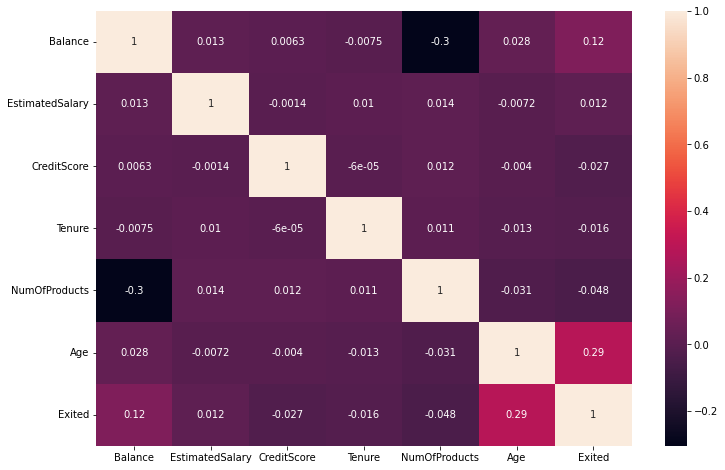

In [32]:
not_cat_col = ['Balance', 'EstimatedSalary', 'CreditScore', 'Tenure', 'NumOfProducts', 'Age']
plt.figure(figsize=(12, 8))
sns.heatmap(df[not_cat_col + ['Exited']].corr(), annot=True);

Мультиколлениарности нет, разобьём данные на тренировочные валидационные и тестовые

In [33]:
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(df, target='Exited',
                                                                           train_size=0.6, valid_size=0.2, 
                                                                            test_size=0.2, random_state=SEED)

print('Train:')
print('X:', x_train.shape, 'y:', y_train.shape)
print()
print('Valid:')
print('X:', x_valid.shape, 'y:', y_valid.shape)
print()
print('Test:')
print('X:', x_test.shape, 'y:', y_test.shape)

Train:
X: (6000, 10) y: (6000,)

Valid:
X: (2000, 10) y: (2000,)

Test:
X: (2000, 10) y: (2000,)


Делаем нормализацию

In [34]:
ss = StandardScaler()
display(x_train[not_cat_col])
print()
x_train[not_cat_col] = ss.fit_transform(x_train[not_cat_col])
x_train[not_cat_col]

,Balance,EstimatedSalary,CreditScore,Tenure,NumOfProducts,Age
8050,0.00,130866.95,707,2,2,33
1265,116973.26,122066.50,534,5,3,55
961,137948.51,113639.64,685,5,1,35
2510,79468.96,84606.03,625,2,1,52
8628,0.00,152884.85,704,3,2,44
...,...,...,...,...,...,...
919,0.00,26752.56,552,9,2,45
4307,190678.02,14725.36,770,9,1,46
5699,135871.50,87219.41,684,6,1,35
537,0.00,127569.80,686,9,2,34


,Balance,EstimatedSalary,CreditScore,Tenure,NumOfProducts,Age
8050,-1.242622,0.532607,0.584215,-1.089514,0.802288,-0.562414
1265,0.633982,0.380518,-1.217221,-0.009659,2.502650,1.533243
961,0.970488,0.234886,0.355131,-0.009659,-0.898075,-0.371900
2510,0.032300,-0.266872,-0.269644,-1.089514,-0.898075,1.247471
8628,-1.242622,0.913119,0.552977,-0.729562,0.802288,0.485414
...,...,...,...,...,...,...
919,-1.242622,-1.266692,-1.029788,1.430149,0.802288,0.580671
4307,1.816428,-1.474546,1.240230,1.430149,-0.898075,0.675929
5699,0.937167,-0.221707,0.344718,0.350293,-0.898075,-0.371900
537,-1.242622,0.475626,0.365544,1.430149,0.802288,-0.467157


Нормализуем валидационную выборку

In [35]:
x_valid[not_cat_col] = ss.transform(x_valid[not_cat_col])
x_valid

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Is_male
8078,-0.779878,France,1.056957,1.070197,-1.242622,0.802288,1,1,-0.730087,0
2655,2.073264,Germany,1.342728,-1.089514,0.266688,0.802288,1,0,-1.089933,1
6094,-0.644510,France,-0.752928,1.790101,0.532302,-0.898075,1,0,0.832482,0
2901,-1.592086,France,3.247871,-1.089514,1.488568,0.802288,1,1,1.129543,1
4211,1.469314,Spain,0.771186,-1.809418,-1.242622,-0.898075,1,1,-1.632977,1
...,...,...,...,...,...,...,...,...,...,...
7835,0.146873,France,0.199643,1.070197,0.299875,-0.898075,1,0,0.639254,0
2416,2.073264,France,0.675929,-0.009659,0.644685,-0.898075,1,0,-0.192306,1
4251,-0.519555,France,-0.371900,-1.089514,-1.242622,0.802288,1,1,0.327233,1
1497,-0.207167,France,-0.371900,1.430149,0.560492,0.802288,1,0,-1.306101,1


Делаем нормализацию тестовой выборки

In [36]:
x_test[not_cat_col] = ss.transform(x_test[not_cat_col])
x_test

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Is_male
9347,0.094808,Spain,-0.276643,-1.809418,0.112027,-0.898075,1,1,1.406772,0
5058,0.657106,France,-0.181385,1.430149,1.139235,0.802288,0,1,0.885401,1
2792,-1.206808,France,0.580671,-1.089514,-1.242622,0.802288,0,1,1.219644,0
3623,0.459260,Germany,-1.133957,-0.009659,0.771626,-0.898075,1,0,0.090610,1
8292,1.375598,Germany,0.199643,-0.009659,0.468213,-0.898075,1,0,1.328942,0
...,...,...,...,...,...,...,...,...,...,...
5870,-0.196754,France,0.390157,-1.089514,0.361896,-0.898075,1,0,-1.309504,1
97,1.698398,Germany,-0.943442,1.070197,0.314937,0.802288,1,1,1.680287,1
8328,-0.134276,Spain,-0.467157,-0.009659,1.110564,-0.898075,1,0,0.036838,1
7140,0.542564,Spain,0.009129,0.350293,1.206912,-0.898075,0,0,1.444907,1


Делаем OneHot-кодировку для тренировочной, валидационной и тестовой

In [37]:
onehotencoder = OneHotEncoder(drop='first', dtype='int')
data_new = onehotencoder.fit_transform(x_train[['Geography']].values)
one_h = pd.DataFrame(data_new.toarray(), columns=onehotencoder.categories_[0][1:], index=x_train[['Geography']].index)
x_train = pd.concat([x_train, one_h], axis=1)
x_train.drop('Geography', axis=1, inplace=True)
x_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Is_male,Germany,Spain
8050,0.584215,-0.562414,-1.089514,-1.242622,0.802288,0,0,0.532607,1,0,0
1265,-1.217221,1.533243,-0.009659,0.633982,2.502650,1,0,0.380518,0,0,0
961,0.355131,-0.371900,-0.009659,0.970488,-0.898075,1,0,0.234886,1,0,1
2510,-0.269644,1.247471,-1.089514,0.032300,-0.898075,1,1,-0.266872,0,0,0
8628,0.552977,0.485414,-0.729562,-1.242622,0.802288,0,1,0.913119,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
919,-1.029788,0.580671,1.430149,-1.242622,0.802288,1,0,-1.266692,1,0,1
4307,1.240230,0.675929,1.430149,1.816428,-0.898075,1,1,-1.474546,1,0,1
5699,0.344718,-0.371900,0.350293,0.937167,-0.898075,1,1,-0.221707,1,0,0
537,0.365544,-0.467157,1.430149,-1.242622,0.802288,1,0,0.475626,1,0,1


In [38]:
data_new_v = onehotencoder.transform(x_valid[['Geography']].values)
one_h_v = pd.DataFrame(data_new_v.toarray(), columns=onehotencoder.categories_[0][1:], index=x_valid[['Geography']].index)
x_valid = pd.concat([x_valid, one_h_v], axis=1)
x_valid.drop('Geography', axis=1, inplace=True)
x_valid

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Is_male,Germany,Spain
8078,-0.779878,1.056957,1.070197,-1.242622,0.802288,1,1,-0.730087,0,0,0
2655,2.073264,1.342728,-1.089514,0.266688,0.802288,1,0,-1.089933,1,1,0
6094,-0.644510,-0.752928,1.790101,0.532302,-0.898075,1,0,0.832482,0,0,0
2901,-1.592086,3.247871,-1.089514,1.488568,0.802288,1,1,1.129543,1,0,0
4211,1.469314,0.771186,-1.809418,-1.242622,-0.898075,1,1,-1.632977,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7835,0.146873,0.199643,1.070197,0.299875,-0.898075,1,0,0.639254,0,0,0
2416,2.073264,0.675929,-0.009659,0.644685,-0.898075,1,0,-0.192306,1,0,0
4251,-0.519555,-0.371900,-1.089514,-1.242622,0.802288,1,1,0.327233,1,0,0
1497,-0.207167,-0.371900,1.430149,0.560492,0.802288,1,0,-1.306101,1,0,0


In [39]:
data_new_t = onehotencoder.transform(x_test[['Geography']].values)
one_h_t = pd.DataFrame(data_new_t.toarray(), columns=onehotencoder.categories_[0][1:], index=x_test[['Geography']].index)
x_test = pd.concat([x_test, one_h_t], axis=1)
x_test.drop('Geography', axis=1, inplace=True)
x_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Is_male,Germany,Spain
9347,0.094808,-0.276643,-1.809418,0.112027,-0.898075,1,1,1.406772,0,0,1
5058,0.657106,-0.181385,1.430149,1.139235,0.802288,0,1,0.885401,1,0,0
2792,-1.206808,0.580671,-1.089514,-1.242622,0.802288,0,1,1.219644,0,0,0
3623,0.459260,-1.133957,-0.009659,0.771626,-0.898075,1,0,0.090610,1,1,0
8292,1.375598,0.199643,-0.009659,0.468213,-0.898075,1,0,1.328942,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5870,-0.196754,0.390157,-1.089514,0.361896,-0.898075,1,0,-1.309504,1,0,0
97,1.698398,-0.943442,1.070197,0.314937,0.802288,1,1,1.680287,1,1,0
8328,-0.134276,-0.467157,-0.009659,1.110564,-0.898075,1,0,0.036838,1,0,1
7140,0.542564,0.009129,0.350293,1.206912,-0.898075,0,0,1.444907,1,0,1


Проверим правильность изменений наших данных

In [40]:
print('Train:')
print('X:', x_train.shape, 'y:', y_train.shape)
print()
print('Valid:')
print('X:', x_valid.shape, 'y:', y_valid.shape)

Train:
X: (6000, 11) y: (6000,)

Valid:
X: (2000, 11) y: (2000,)


## Models

### LogisticRegression

In [41]:
lr_model = LogisticRegression(random_state=SEED).fit(x_train, y_train)
f1_score(lr_model.predict(x_valid), y_valid)

0.30855018587360594

### DecisionTree

In [42]:
tree_model = DecisionTreeClassifier(random_state=SEED).fit(x_train, y_train)
f1_score(tree_model.predict(x_valid), y_valid)

0.5059952038369304

### RandomForest

In [43]:
forest_model = RandomForestClassifier(random_state=SEED).fit(x_train, y_train)
f1_score(forest_model.predict(x_valid), y_valid)

0.5772870662460567

### LogisticRegression

In [44]:
%%time

params = {'max_iter': range(10, 210, 10)}

model = LogisticRegression(solver='liblinear', random_state=SEED)

gs = GridSearchCV(estimator=model, param_grid=params, scoring='f1')
gs.fit(x_train, y_train)
gs.best_params_

CPU times: total: 1.5 s
Wall time: 2.09 s


{'max_iter': 10}

0.30855018587360594


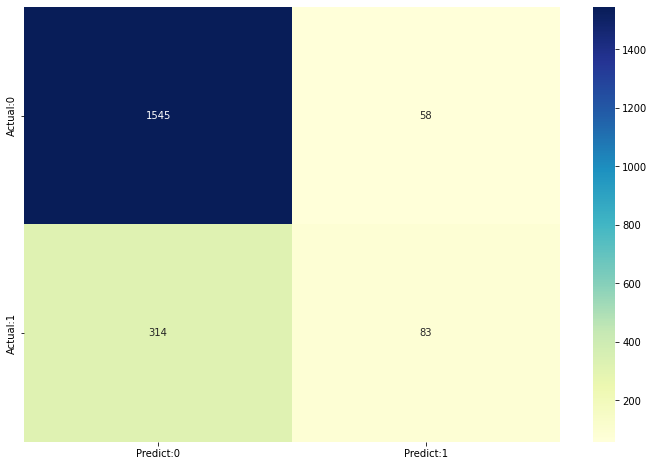

In [45]:
best_lr = LogisticRegression(max_iter=10, solver='liblinear', random_state=SEED).fit(x_train, y_train)
y_pred = best_lr.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

Из-за дизбаланса классов, модель лучше предсказывает класс **0** и ошибается на нём реже(примерно 1 раз на 26 объектах). Модель хуже предсказывает класс **1**(ошибается примерно 3 разa на 4 объектах, т.е. модель ошибается на каждом втором нулевом классе). Дальнейшее решение это проблемы - баланс классов, переходим к бэггингу.

### DecisionTree

In [46]:
%%time

best_model = None
best_score = 0
for depth in range(5, 35, 5):
    for leaf in range(1, 6):
        for split in range(2, 12, 2):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_split=split,
                                    min_samples_leaf=leaf, random_state=SEED).fit(x_train, y_train)
            f1 = f1_score(model.predict(x_valid), y_valid)
            if f1 > best_score:
                best_score = f1
                best_model = model
print(best_model, '---> f1:', best_score)

DecisionTreeClassifier(max_depth=10, random_state=7) ---> f1: 0.5706134094151213
CPU times: total: 5.36 s
Wall time: 6.48 s


0.5706134094151213


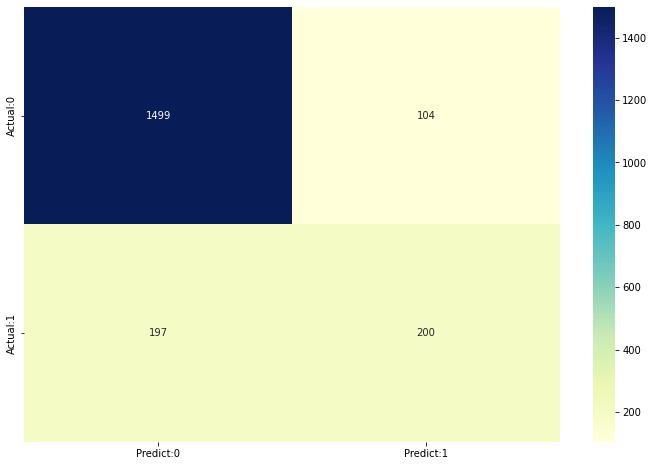

In [47]:
best_tree = DecisionTreeClassifier(max_depth=10, random_state=SEED).fit(x_train, y_train)
y_pred = best_tree.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

Из-за дизбаланса классов, модель лучше предсказывает класс 0 и ошибается на нём реже(примерно 1 раз на 14 объектах). Модель хуже предсказывает класс 1(ошибается примерно 1 раз на 2 объектах, т.е. модель ошибается на каждом втором нулевом классе). Дальнейшее решение это проблемы - баланс классов, переходим к бэггингу.

### RandomForest

In [48]:
%%time

best_model = None
best_score = 0
for est in range(100, 600, 100):
    for depth in range(5, 35, 5):
        for leaf in range(1, 6):
            for split in range(2, 12, 2):
                model = RandomForestClassifier(n_estimators=est, max_depth=depth, 
                                       min_samples_leaf=leaf, min_samples_split=split, 
                                       random_state=SEED).fit(x_train, y_train)
                f1 = f1_score(model.predict(x_valid), y_valid)
                if f1 > best_score:
                    best_score = f1
                    best_model = model
    print(f'Done with {est} estimators')
print(best_model, '---> f1:', best_score)

Done with 100 estimators
Done with 200 estimators
Done with 300 estimators
Done with 400 estimators
Done with 500 estimators
RandomForestClassifier(max_depth=20, n_estimators=400, random_state=7) ---> f1: 0.5865834633385335
CPU times: total: 23min 57s
Wall time: 37min 43s


0.5865834633385335


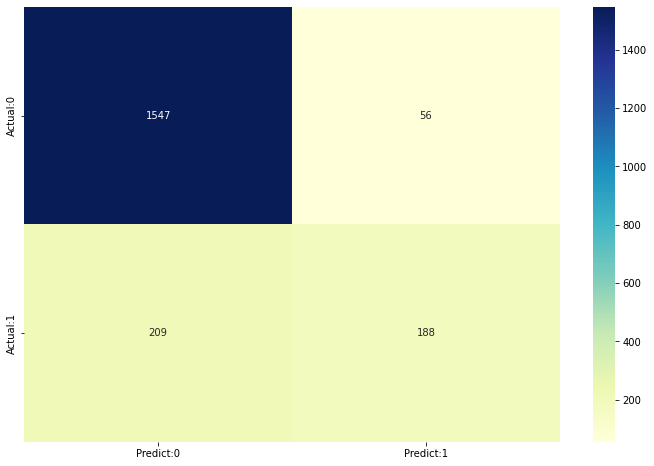

In [49]:
best_forest = best_model
y_pred = best_forest.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

Из-за дизбаланса классов, модель лучше предсказывает класс **0** и ошибается на нём реже(примерно 1 раз на 28 объектах). Модель хуже предсказывает класс **1**(ошибается примерно 1 раз на 2 объектах, т.е. модель ошибается на каждом втором нулевом классе). Дальнейшее решение это проблемы - баланс классов, переходим к бэггингу.

## Борьба с дисбалансом

### Upsampling

Будем бороться с дизбалансом классов с помощью upsampling

In [50]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=SEED)
    
    return features_upsampled, target_upsampled


x_upsampled, y_upsampled = upsample(x_train, y_train, 4)

### LogisticRegression

In [51]:
%%time

best_model = None
best_score = 0
for iter in range(10, 210, 10):
    model = LogisticRegression(max_iter=iter, solver='liblinear', random_state=SEED).fit(x_upsampled, y_upsampled)
    f1 = f1_score(model.predict(x_valid), y_valid)
    if f1 > best_score:
        best_score = f1
        best_model = model
print(best_model, '---> f1:', best_score)

LogisticRegression(max_iter=10, random_state=7, solver='liblinear') ---> f1: 0.4995617879053462
CPU times: total: 297 ms
Wall time: 561 ms


0.4995617879053462


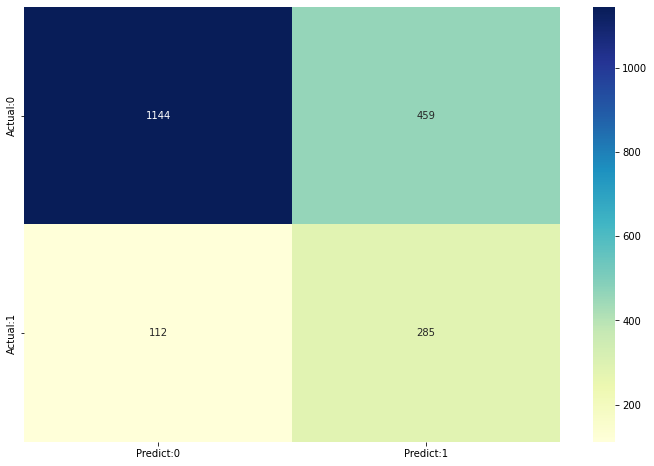

In [52]:
best_lr = best_model
y_pred = best_lr.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

### DecisionTree

In [53]:
%%time

best_model = None
best_score = 0
for depth in range(5, 35, 5):
    for leaf in range(1, 6):
        for split in range(2, 12, 2):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_split=split,
                                    min_samples_leaf=leaf, random_state=SEED).fit(x_upsampled, y_upsampled)
            f1 = f1_score(model.predict(x_valid), y_valid)
            if f1 > best_score:
                best_score = f1
                best_model = model
print(best_model, '---> f1:', best_score)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=7) ---> f1: 0.5432314410480349
CPU times: total: 5.73 s
Wall time: 8.31 s


0.5432314410480349


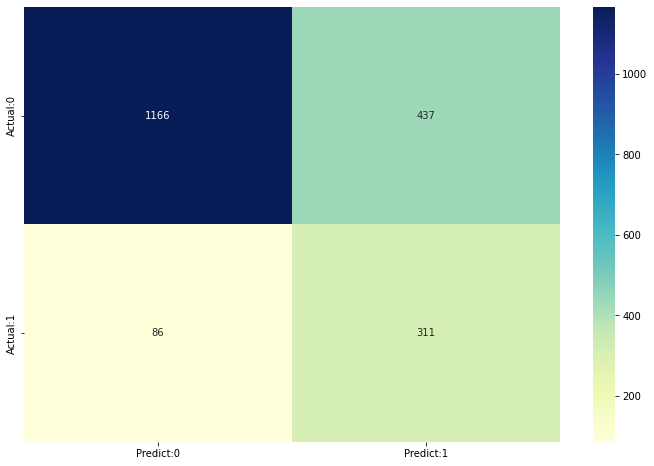

In [54]:
best_tree = best_model
y_pred = best_tree.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

### RandomForest

In [68]:
%%time

best_model = None
best_score = 0
for est in range(100, 600, 100):
    for depth in range(5, 35, 5):
        for leaf in range(1, 6):
            for split in range(2, 12, 2):
                model = RandomForestClassifier(n_estimators=est, max_depth=depth, 
                                           min_samples_leaf=leaf, min_samples_split=split, 
                                           random_state=SEED).fit(x_upsampled, y_upsampled)
                f1 = f1_score(model.predict(x_valid), y_valid)
                if f1 > best_score:
                    best_score = f1
                    best_model = model
    print(f'Done with {est} estimators')
print(best_model, '---> f1:', best_score)

Done with 100 estimators
Done with 200 estimators
Done with 300 estimators
Done with 400 estimators
Done with 500 estimators
RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=300, random_state=7) ---> f1: 0.6310432569974554
CPU times: total: 36min 30s
Wall time: 50min 34s


0.6310432569974554


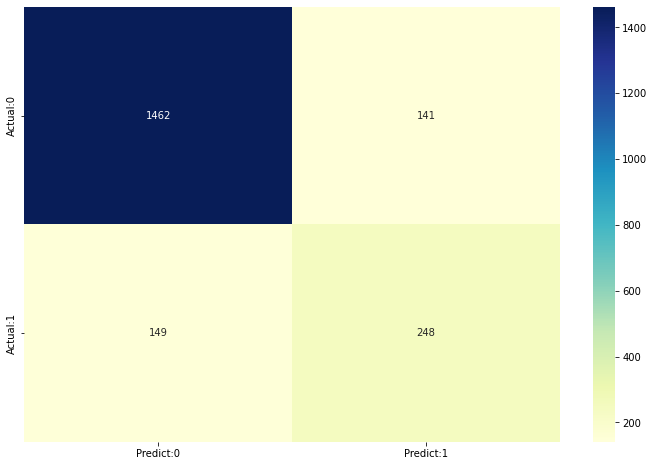

In [56]:
best_forest = best_model
y_pred = best_forest.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

При использовании upsampling, мы смогли повысить f1-меру на LogisticRegression до 0.49, на DecisionTreeClassifier до 0.54, на RandomForestClassifier до 0.63

### Downsampling

Теперь попробуем бороться с дизбалансом классов с помощью downsampling

In [57]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=SEED)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=SEED)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=SEED)
    
    return features_downsampled, target_downsampled

x_downsampled, y_downsampled = downsample(x_train, y_train, 0.25)

### LogisticRegression

In [58]:
%%time

best_model = None
best_score = 0
for iter in range(10, 210, 10):
    model = LogisticRegression(max_iter=iter, solver='liblinear', random_state=SEED).fit(x_downsampled, y_downsampled)
    f1 = f1_score(model.predict(x_valid), y_valid)
    if f1 > best_score:
        best_score = f1
        best_model = model
print(best_model, '---> f1:', best_score)

LogisticRegression(max_iter=10, random_state=7, solver='liblinear') ---> f1: 0.4974003466204505
CPU times: total: 15.6 ms
Wall time: 220 ms


0.4974003466204505


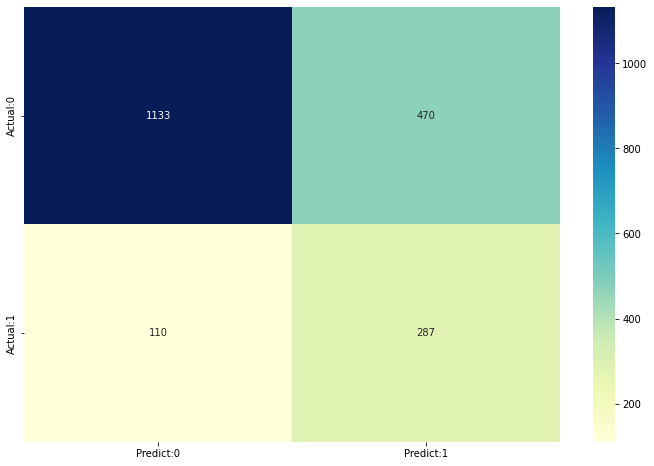

In [59]:
best_lr = best_model
y_pred = best_lr.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

### DecisionTree

In [60]:
%%time

best_model = None
best_score = 0
for depth in range(5, 35, 5):
    for leaf in range(1, 6):
        for split in range(2, 12, 2):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_split=split,
                                     min_samples_leaf=leaf, random_state=SEED).fit(x_downsampled, y_downsampled)
            f1 = f1_score(model.predict(x_valid), y_valid)
            if f1 > best_score:
                best_score = f1
                best_model = model
print(best_model, '---> f1:', best_score)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=10,
                       random_state=7) ---> f1: 0.5529953917050692
CPU times: total: 2.06 s
Wall time: 2.7 s


0.5529953917050692


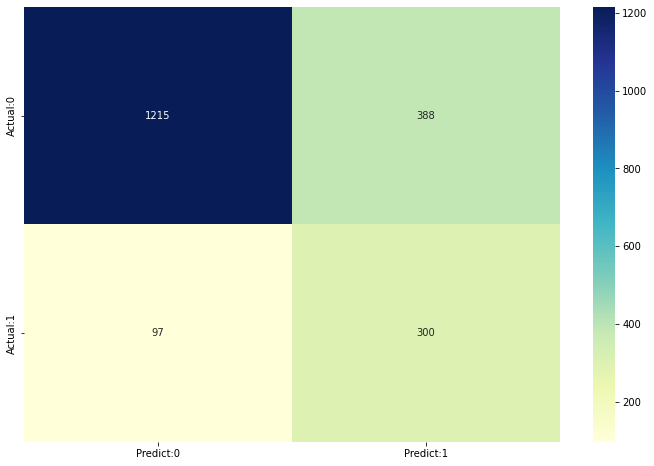

In [61]:
best_tree = best_model
y_pred = best_tree.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

### RandomForest

In [69]:
%%time

best_model = None
best_score = 0
for est in range(100, 600, 100):
    for depth in range(5, 35, 5):
        for leaf in range(1, 6):
            for split in range(2, 12, 2):
                model = RandomForestClassifier(n_estimators=est, max_depth=depth, 
                                       min_samples_leaf=leaf, min_samples_split=split, 
                                       random_state=SEED).fit(x_downsampled, y_downsampled)
                f1 = f1_score(model.predict(x_valid), y_valid)
                if f1 > best_score:
                    best_score = f1
                    best_model = model
    print(f'Done with {est} estimators')
print(best_model, '---> f1:', best_score)

Done with 100 estimators
Done with 200 estimators
Done with 300 estimators
Done with 400 estimators
Done with 500 estimators
RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=300,
                       random_state=7) ---> f1: 0.6047904191616766
CPU times: total: 12min 26s
Wall time: 17min 58s


0.6047904191616766


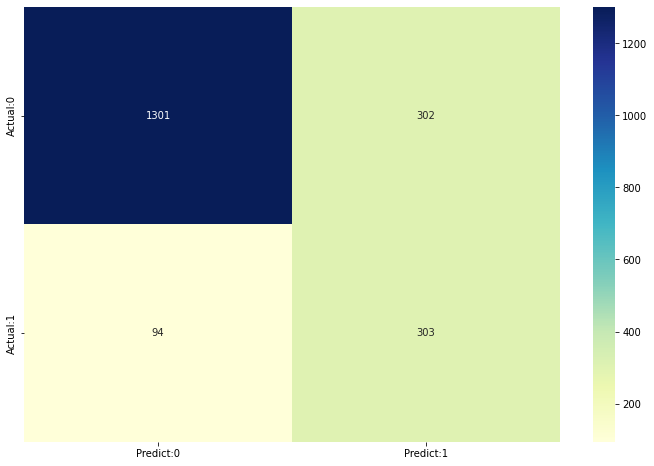

In [63]:
best_forest = best_model
y_pred = best_forest.predict(x_valid)

print(f1_score(y_pred, y_valid))

cm = confusion_matrix(y_valid, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict:0', 'Predict:1'], 
                                 index=['Actual:0', 'Actual:1'])

plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

При использовании upsampling, мы смогли повысить f1-меру на LogisticRegression до 0.49, на DecisionTreeClassifier до 0.55, на RandomForestClassifier до 0.6

Финальной моделью становиться случайный лес, обученный с помощью увеличения выборки т.к. по метрикам он лучше.

## Тестирование модели

In [71]:
best_forest = RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=300, random_state=7).fit(x_upsampled, y_upsampled)

In [72]:
y_pred_test = best_forest.predict(x_test)
probabilities_test = best_forest.predict_proba(x_test)[:, 1]

print('f1_score forest:', f1_score(y_test, y_pred_test))
print('acc on forest:', accuracy_score(y_test, y_pred_test))
print('roc_auc on forest:', roc_auc_score(y_test, probabilities_test))

f1_score forest: 0.6032138442521632
acc on forest: 0.8395
roc_auc on forest: 0.8587570621468925


## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: задача исследована
    - [X]  Исследован баланс классов
    - [X]  Изучены модели без учёта дисбаланса
    - [X]  Написаны выводы по результатам исследования
- [X]  Выполнен шаг 3: учтён дисбаланс
    - [X]  Применено несколько способов борьбы с дисбалансом
    - [X]  Написаны выводы по результатам исследования
- [X]  Выполнен шаг 4: проведено тестирование
- [X]  Удалось достичь *F1*-меры не менее 0.59
- [X]  Исследована метрика *AUC-ROC*